# Klausur

## Task 1

In [3]:
using CairoMakie
using Plots;
Plots.pyplot()
using FFTW
using LaTeXStrings
using Distributed
using ProgressMeter
using Profile

## Task 4

In [132]:


"""
Computes gradient of a 2D scalar field.

`T` is a scalar field in direct space.

Returns a vector field in direct space.
"""
function f_grad(T,Nx, Ny, Lx, Ly,dx,dy)
    T = real(ifft(T))

    kxf = Nx*fftfreq(Nx)*2*pi*im/Lx
    kyf = Ny*fftfreq(Ny)*2*pi*im/Ly

    #=
    for i in 1:size(T,2)
        dx[:,i] = fft(T[:,i]).*kxf
    end
    =#
    #=
    # Derivative in y direction
    for i in 1:size(T,1)
        dy[i,:] = fft(T[i,:]).*kyf
    end
    =#
    T = fft(T)


    #print(eachcol(T)[1])

    dx = real(ifft(hcat((eachrow(T) .*kxf)...))')
    dy = real(ifft(hcat((eachcol(T) .*kyf)...)))

    return [dx,dy]
end



"""
Differentiates `x` in fourier space.

`x` is a 1d array.

Returns real part of the inverse fourier transform.
"""
function f_diff(x,N,L)
    k = N*fftfreq(N)
    diff = ifft(2*pi*im/L*k.*fft(x))
    return real(diff)
end


"""
Returns real fourier coeffs of v⋅∇T.

`v` is a vector field in direct space.

`T` is a scalar field in direct space.

"""
function v∇T(v,T,Nx,Ny,Lx,Ly,dx,dy)
    ∇T = f_grad(T,Nx,Ny,Lx,Ly,dx,dy)
    return fft(∇T[1].*v[1] .+ ∇T[2].*v[2])
end

"Computes the element-wise scalar product of two vector fields"
function scalarProductVecField(a,b)
    return getindex.(a,1).*getindex.(b,1) + getindex.(a,2).*getindex.(b,2)
end


"Test source term Q in fourier space"
function test_source(Nx,Ny,Lx,Ly)
    Q = fill(0.0,Nx,Ny)
    for i in 1:Nx
        for j in 1:Ny
            x = Lx/Nx*i
            y = Ly/Ny*j
            Q[i,j] = -2*pi^2*sin(4*pi*x)*cos(2*pi*y)*sin(2*pi*x)*sin(2*pi*y) - 4*pi^2*cos(4*pi*x)*sin(2*pi*y)*cos(2*pi*x)*cos(2*pi*y) + 8*pi^2*cos(2*pi*x)*sin(2*pi*y)
        end
    end
    return fft(Q)
end


function gauss_source(Nx,Ny,Lx,Ly,σ)
    Q = fill(0.0,Nx,Ny)
   
    for i in 1:Nx
        for j in 1:Ny
            x = Lx/Nx * i
            y = Ly/Ny * j
            Q[i,j] = 1/(2*pi*σ^2)*exp(-((x-0.5*Lx)^2 + y^2)/(2*σ^2))
        end
    end
    return fft(Q) 
end

"""
Time step for the integration of the temperature field.
`T_hist` is the temperature field in fourier space.

`v_hist` is the velocity field in fourier space.

`hats` is an array of prevoiusly calculated v⋅∇T.

Returns new temperature field in fourier space.
"""
function T_step(T,hat,hat_old,Nx,Ny,kx,ky,Δt,Q)

    #T_new = Matrix{ComplexF64}(undef, Nx, Ny)
   
    for i in 1:size(T,1)
        for j in 1:size(T,2)
            T[i,j] = 1/(1+Δt*0.5*(kx[i]^2+ky[j]^2))*(T[i,j]+Δt*(-0.5*(kx[i]^2+ky[j]^2)*T[i,j]-0.5*(3*hat[i,j]-hat_old[i,j])+Q[i,j]))
        end
    end
    
    return T
end


T_step

In [133]:
"Calculates the sum of the elementwise absolute diffrence between two scalar fields"
function abs_change(a,b)
    diff = a - b
    change = sum(abs.(diff))
    return change
end

"Initial velocity vector field"
function test_velocity(Nx,Ny,Lx,Ly)
    v = Vector{Matrix{Float64}}
    v = [zeros(Float64,Nx,Ny),zeros(Float64,Nx,Ny)]
    for i in 1:Nx
        for j in 1:Ny
            v[1][i,j] = pi*sin(4*pi*(Lx/(Nx))*(i))*cos(2*pi*(Ly/(Ny))*((j)))
            v[2][i,j] = -2*pi*cos(4*pi*(Lx/(Nx))*(i))*sin(2*pi*(Ly/(Ny))*((j)))
        end
    end
    return v
end

"""
Updates the velocity field for a given `T` in fourier space.

Returns velocity vector field in fourier space. 
"""
function update_velocity(T,v,Nx,Ny,kx,ky,Ra)

    k_abs = kx.^2 .+ (ky.^2)'
    for i in 1:Nx
        for j in 1:Ny
            if k_abs[i,j] != 0
                v[1][i,j] = ((-kx[i]*ky[j]/k_abs[i,j])*T[i,j]*Ra)/(k_abs[i,j])
                v[2][i,j] = ((-ky[j]*ky[j]/k_abs[i,j] + 1)*T[i,j]*Ra)/(k_abs[i,j])
            else
                v[1][i,j] = 0.0
                v[2][i,j] = 0.0
            end
        end
    end

    v[1] = real(ifft(v[1]))
    v[2] = real(ifft(v[2]))
    return v
end

function target_T(Nx,Ny,Lx,Ly)
    target = fill(0.0, (Nx,Ny))
    for i in 1:Nx
        for j in 1:Ny
            target[i,j] = cos(2.0*pi*Lx/Nx*i)*sin(2*pi*Ly/Ny*j)
        end
    end
    return target
end

target_T (generic function with 1 method)

## Task 5

Zero

nothing

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


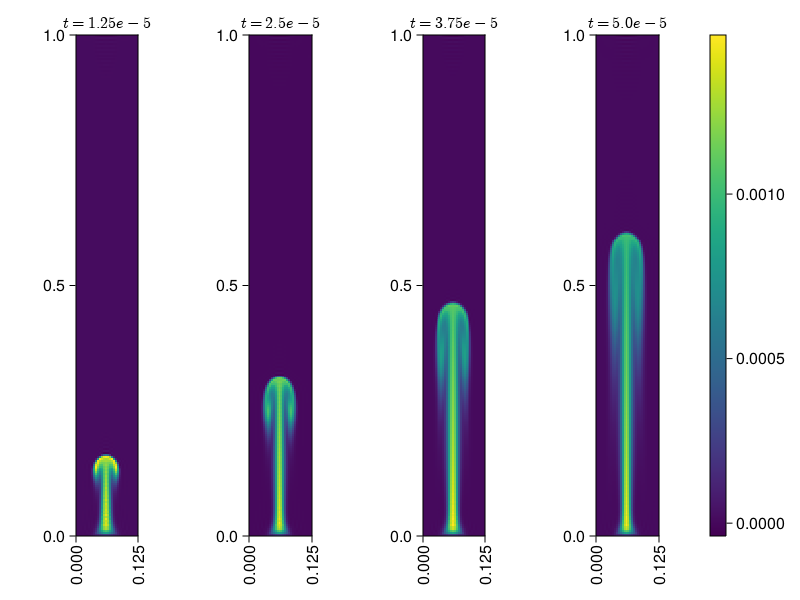

In [191]:
"""
Integrates the temperature field `T` with an initial velocity field `v` for `steps` steps with timestep `timestep`.

Returns an array containing all calculated temperature fields in fourier space.
"""
function integrate(geometry,timestep,steps,v,T,Q,dynamic=false,save_interval = 1,Ra=1,return_v=false)
    Nx = geometry[1][1]
    Ny = geometry[1][2]
    Lx = geometry[2][1]
    Ly = geometry[2][2]

    dx = zeros(ComplexF64,Nx,Ny)
    dy = zeros(ComplexF64,Nx,Ny)

    kx = 2*pi*fftfreq(Nx)*Nx/Lx
    ky = 2*pi*fftfreq(Ny)*Ny/Ly


    kxf = Nx*fftfreq(Nx)*2*pi*im/Lx
    kyf = Ny*fftfreq(Ny)*2*pi*im/Ly

    v_factor = Vector{Matrix{ComplexF64}}(undef, 2)
    v_factor[1] = zeros(ComplexF64,Nx,Ny)
    v_factor[2] = zeros(ComplexF64,Nx,Ny)


    diff_factor = [2*pi*im/Lx*kx,2*pi*im/Ly*ky]




    T_hist = [fft(copy(T)),fft(copy(T))]
    v_hist = [copy(v)]
    T_new = fft(copy(T))
    
    hat_old = v∇T(v_hist[end],T_hist[end - 1],Nx,Ny,Lx,Ly,dx,dy)
    T_old = fft(copy(T))
    @showprogress for i in 1:steps

        # Calculate ℱ(v⋅∇T) #
        hat = v∇T(v,T_old,Nx,Ny,Lx,Ly,dx,dy)
        
        # Timestep for integration of T #
        T_new = T_step(T_old,hat,hat_old,Nx,Ny,kx,ky,timestep,Q)
        hat_old = copy(hat)


        T_old = T_new

        # Update velocity field #
        if dynamic
            v = copy(update_velocity(T_new,v,Nx,Ny,kx,ky,Ra))
        end

        if i%(save_interval)==0
            push!(T_hist,copy(T_new))
            push!(v_hist,copy(v))
        end

    end
    #display(Plots.heatmap(real.(v_hist[end][1])))
    #display(Plots.heatmap(real.(v_hist[end][2])))
    if !return_v
        return T_hist
    else
        return T_hist, v_hist
    end
end



function test_function(plot_mode,geometry,timestep,steps,Q_mode="test",v_mode="test",Ra=1.0,σ=0.01)
    Nx = geometry[1][1]
    Ny = geometry[1][2]
    Lx = geometry[2][1]
    Ly = geometry[2][2]
    # Initial temperature field #
    T = fill(0.0, (Nx,Ny))
    for i in 1:Nx
        for j in 1:Ny
            T[i,j] = 0
        end
    end
    Q = gauss_source(Nx,Ny,Lx,Ly,σ)
    if Q_mode == "test"
        Q = test_source(Nx,Ny,Lx,Ly)
        display(print("test"))
    end

    if v_mode == "test"
        v = test_velocity(Nx,Ny,Lx,Ly)
    else
        display(print("Zero"))
        v = Vector{Matrix{ComplexF64}}(undef, 2)
        v[1] = zeros(ComplexF64,Nx,Ny)
        v[2] = zeros(ComplexF64,Nx,Ny)
    end


    if plot_mode == "gif"
        anim = @animate for h in integrate(geometry,timestep,steps,v,T,Q)
            #heatmap(real(ifft(h)),c= :magma)
            heatmap(real(ifft(h)))
        end every 100
        display(gif(anim, "heatmap.gif",fps=15))
    end


    # Plot maximum temperature to find stationaty solution #
    if plot_mode == "max"
        maxx = []
        for h in integrate(geometry,timestep,steps,v,T,Q)
            append!(maxx,maximum(real(ifft(h))))
        end
        display(plot(maxx))
    end
    

    if plot_mode == "v"
        plotx = heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),v[1]',title=L"$\vec{v}_y$",xlabel=L"$x$",ylabel=L"$y$",aspect_ratio=:equal,clim = (-5, 5))
        ploty = heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),v[2]',title=L"$\vec{v}_x$",xlabel=L"$x$",ylabel=L"$y$",aspect_ratio=:equal,clim = (-5, 5))
        display(plot(ploty,plotx,size=(800,400),link=:all,layout=(1,2),sharey = true, legend=:none))
    end

    if plot_mode == "roc"
        cc = []
        t_max = 1
        timesteps = [0.01 0.05 0.1]
        plt_absolute = plot()
        plt_change = plot()
        for i in timesteps'
            diff_t_star = []
            change = []
            steps = floor(t_max/i)
            T_hist = integrate(geometry,i,steps,v,T,Q)
            for i in 2:length(T_hist)
                push!(change,abs_change(real(ifft(T_hist[i])),real(ifft(T_hist[i-1]))))
                push!(diff_t_star,sum(abs.(real(ifft(T_hist[i])) - target_T(Nx,Ny,Lx,Ly)))) 
            end
            plt_change = plot!(plt_change,(0:i:steps*i),change,label=L"$\Delta t = $" .* string.(i),ylim=(0,100),xlabel="Time",ylabel=L"$\sum_{ij}\vert T_{ij}^n-T_{ij}^{n-1}\vert$",title=L"Absolute difference between $T^{n}$ and $T^{n-1}$")
            plt_absolute = plot!(plt_absolute,(0:i:steps*i),diff_t_star,label=L"$\Delta t = $" .* string.(i),ylim=(0,500),xlabel="Time",ylabel=L"$\vert T^\star- T^n \vert$",title=L"Absolute difference between $T^\star$ and $T^{n}$")
            #push!(cc,plot((0:i:steps*i),c,label=L"$\Delta t = $" .* string.(i),ylim=(0,100),xlabel="Timesteps",ylabel=L"$\sum_{ij}\vert T_{ij}^n-T_{ij}^{n-1}\vert$"))


        end
        display(plot(plt_absolute))
    end

    if plot_mode == "Q"
        display(heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),real(ifft(Q))',title=L"Source term $Q^\star$",aspect_ratio=:equal,xlabel=L"$x$",ylabel=L"$y$",size=(600,600)))
    end

    if plot_mode == "final"
        T = real(ifft(integrate(geometry,timestep,steps,v,T,Q)[end]))'
        display(Plots.heatmap((0:(Lx/Nx):Lx),(0:(Ly/Ny):Ly),T,title=L"$T$ after " * string(steps) * " time steps",aspect_ratio=:equal,xlabel=L"$x$",ylabel=L"$y$",size=(600,600)))
        print(maximum(T))
    end

    if plot_mode == "test"
        T = real(ifft(integrate(geometry,timestep,steps,v,T,Q)[end]))
        display(heatmap(target_T(Nx,Ny,Lx,Ly) - T,aspect_ratio=:equal,right_margin = 10Plots.mm))
    end

    if plot_mode == "testVelocity"
        Nx = 32
        Ny = 32
        Lx = 1.0
        Ly = 1.0
        kx = 2*pi*fftfreq(Nx)*Nx/Lx
        ky = 2*pi*fftfreq(Ny)*Ny/Ly
        v = Vector{Matrix{ComplexF64}}(undef, 2)
        v[1] = zeros(ComplexF64,Nx,Ny)
        v[2] = zeros(ComplexF64,Nx,Ny)
        v = update_velocity(fft(target_T(Nx,Ny,Lx,Ly)),v,Nx,Ny,kx,ky,Ra)
        vx = v[1]
        vy = v[2]
        
        #vx,vy = normalize(vx,vy)
        
        xs = 1:Nx
        ys = 1:Ny
        
        xxs = [x for x in xs for y in ys]
        yys = [y for x in xs for y in ys]

        f = Figure()
        ax = Axis(f[1, 1],
            title = L"Temperature field $T^*$ and velocity field $\vec{v}$",
            xlabel = L"x",
            ylabel = L"y"
        )
        
        
        hm = CairoMakie.heatmap!(ax,xs,ys,target_T(Nx,Ny,Lx,Ly))
        #GRUtils.quiver(x,y,vy,vx)
        #GRUtils.heatmap(target_T(Nx,Ny,Lx,Ly))
        #display(heatmap(real(vy)))
        sp = CairoMakie.quiver!(ax,xs,ys,vx,vy, lengthscale = 100)
        Colorbar(f[:, end+1], hm)
        display(f)
    end

    if plot_mode == "task7"
        f = Figure()
        Ts, vs = integrate(geometry,timestep,steps,v,T,Q,true,steps/4,Ra,true)
        for i in 3:length(Ts)
            time = round(steps/4*(i-2)*timestep,digits=8)
            ax = Axis(f[1, i-2],
                aspect = Nx/Ny,
                title = L"t=%$(time)",
                xticklabelrotation = pi/2,
                xticks = [0,Lx]
            )
            #title = L"Temperature field $T$ after %$(steps) time steps with $\Delta t =$ %$(timestep), $Ra =$ %$(Ra) and $\sigma = $ %$(σ)",
            #xlabel = L"x",
            #ylabel = L"y",
            xs = 0:(Lx/Nx):Lx
            ys = 0:(Ly/Ny):Ly
            
            hm = CairoMakie.heatmap!(ax,xs,ys,real(ifft(Ts[i])))
        end
            #sp = CairoMakie.quiver!(ax,xs,ys,real(vs[end][1]),real(vs[end][2]), lengthscale = 0.0001)
        Colorbar(f[:, end+1], hm)
        display(f)
    end

end

Nx = 32
Ny = 32
Lx = 1.0
Ly = 1.0

geometry = ((Nx,Ny),(Lx,Ly))
timestep = 0.001
steps = 800

#test_function("final",geometry,0.001,400)


Nx = 32
Ny = 8*Nx
Lx = 1.0/8.0
Ly = 1.0

geometry = ((Nx,Ny),(Lx,Ly))
timestep = 1e-8
steps = 5000
#test_function("testVelocity",geometry,timestep,steps)
test_function("task7",geometry,timestep,steps,"gauss","zero",1e11,0.01)


## Task 6

test_v_update (generic function with 1 method)

source_distribution (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:16:02


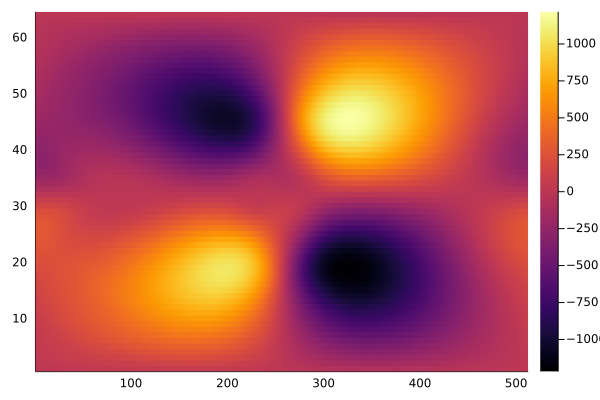

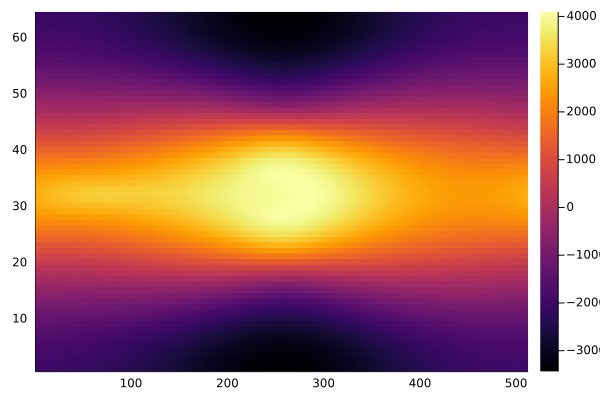

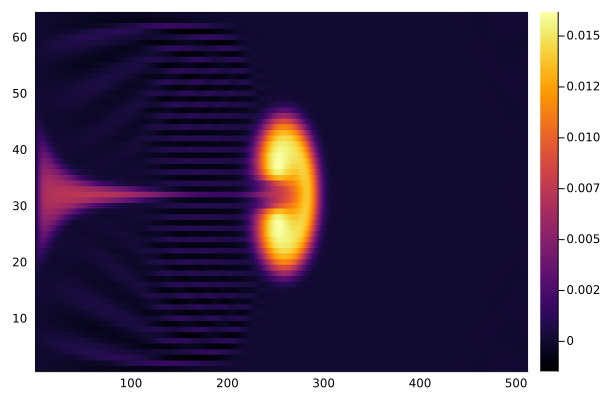

┌ Info: Saved animation to 
│   fn = /home/jovyan/tmp.gif
└ @ Plots /opt/julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/home/jovyan/tmp.gif")
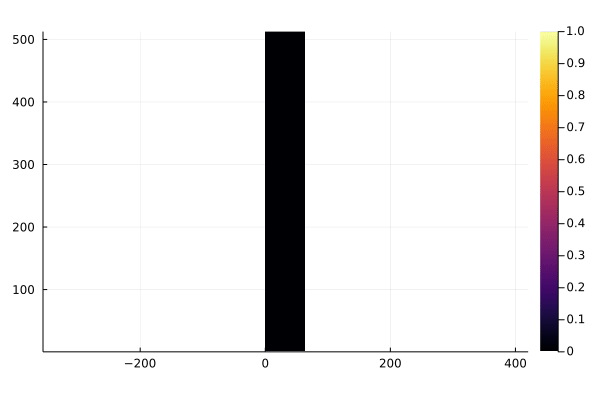

In [16]:
@gif for i in Ts
    heatmap(real(ifft(i)'),aspect_ratio=:equal)
end


In [45]:
Matrix{Vector{Float64}}(undef, Nx, Ny)


LoadError: TypeError: in Type, in parameter, expected Type, got a value of type Matrix{Float64}

LoadError: syntax: more than one semicolon in argument list around In[17]:1

In [160]:
Nx = 32
Ny = 32
Lx = 1.0
Ly = 1.0

geometry = ((Nx,Ny),(Lx,Ly))
timestep = 0.001
steps = 400



400

In [94]:
T = Matrix{Float64}(undef, 3,3)
T = [1 2 3 ; 4 5 6 ; 7 8 9]
a = [1,2,3]

mapslices(sum ,T', dims=[1])
y = hcat((eachcol(T) .* a)...)
x = hcat((eachrow(T) .* a)...)'
y


3×3 Matrix{Int64}:
 1   4   9
 4  10  18
 7  16  27